In [1]:
import numpy as np
from keras.layers import Dense, Input, Add
from keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
from scipy import special
import keras.backend as K

from Source import RM

Using TensorFlow backend.


In [9]:
m = 4
r = 1
length = 2**m

G = RM.G_matrix(length, m, r)
G_p = RM.G_prime(G, m)

if r == 1:
    masking_length=0
else:
    masking_length=int(np.math.factorial(m)/(np.math.factorial(2)*np.math.factorial(m-2)))

In [10]:
with K.tf.device('/gpu:0'):
    model_1 = load_model('Model/model_(1,4)_p1.h5')
    model_2 = load_model('Model/model_(1,4)_p2.h5')
    model_3 = load_model('Model/model_(1,4)_p3.h5')
    model_4 = load_model('Model/model_(1,4)_p4.h5')
    model_5 = load_model('Model/model_(1,4)_p5.h5')

In [11]:
with K.tf.device('/gpu:0'):
    total_model_1_BER = np.zeros(11)
    total_model_2_BER = np.zeros(11)
    total_model_3_BER = np.zeros(11)
    total_model_4_BER = np.zeros(11)
    total_model_5_BER = np.zeros(11)

In [12]:
with K.tf.device('/gpu:0'):
    file_buffer = 'Result/model_(1,4)_p1.csv'
    model_1_f = open(file_buffer, 'w')

    file_buffer = 'Result/model_(1,4)_p2.csv'
    model_2_f = open(file_buffer, 'w')

    file_buffer = 'Result/model_(1,4)_p3.csv'
    model_3_f = open(file_buffer, 'w')

    file_buffer = 'Result/model_(1,4)_p4.csv'
    model_4_f = open(file_buffer, 'w')

    file_buffer = 'Result/model_(1,4)_p5.csv'
    model_5_f = open(file_buffer, 'w')

In [13]:
with K.tf.device('/gpu:0'):
    for i in range(0, 11):
        model_1_BER = 0
        model_2_BER = 0
        model_3_BER = 0
        model_4_BER = 0
        model_5_BER = 0
        print('snr', i)
        for j in range(10):
            msg = np.random.randint(2, size = (10**4, m+r+masking_length))
            send_code, recived_code = RM.Encoding(msg, G, i, length)
           
            model_1_ae_code = model_1.predict(recived_code, verbose=0)
            model_1_ae_code = np.reshape(model_1_ae_code, send_code.shape)
            model_2_ae_code = model_2.predict(recived_code, verbose=0)
            model_2_ae_code = np.reshape(model_2_ae_code, send_code.shape)
            model_3_ae_code = model_3.predict(recived_code, verbose=0)
            model_3_ae_code = np.reshape(model_3_ae_code, send_code.shape)
            model_4_ae_code = model_4.predict(recived_code, verbose=0)
            model_4_ae_code = np.reshape(model_4_ae_code, send_code.shape)
            model_5_ae_code = model_5.predict(recived_code, verbose=0)
            model_5_ae_code = np.reshape(model_5_ae_code, send_code.shape)
 
            hard_recived_code = np.where(recived_code > 0, 1, -1)
            hard_model_5_ae_code = np.where(model_5_ae_code > 0, 1, -1)
            check = hard_recived_code * hard_model_5_ae_code
            check_index = np.where(check == -1)
            recived_5_code = recived_code
            recived_5_code[check_index] = hard_model_5_ae_code[check_index]
            
            model_1_estimated_code = RM.Decoding(model_1_ae_code, m, length, r, G, G_p)
            model_2_estimated_code = RM.Decoding(model_2_ae_code, m, length, r, G, G_p)
            model_3_estimated_code = RM.Decoding(model_3_ae_code, m, length, r, G, G_p)
            model_4_estimated_code = RM.Decoding(model_4_ae_code, m, length, r, G, G_p)
            model_5_estimated_code = RM.Decoding(recived_5_code, m, length, r, G, G_p)
        
            model_1_count = ((msg + model_1_estimated_code)%2).sum()
            model_2_count = ((msg + model_2_estimated_code)%2).sum()
            model_3_count = ((msg + model_3_estimated_code)%2).sum()
            model_4_count = ((msg + model_4_estimated_code)%2).sum()
            model_5_count = ((msg + model_5_estimated_code)%2).sum()
        
            model_1_BER += model_1_count / (msg.shape[0] * msg.shape[1])
            model_2_BER += model_2_count / (msg.shape[0] * msg.shape[1])
            model_3_BER += model_3_count / (msg.shape[0] * msg.shape[1])
            model_4_BER += model_4_count / (msg.shape[0] * msg.shape[1])
            model_5_BER += model_5_count / (msg.shape[0] * msg.shape[1])
    
        total_model_1_BER[i] = model_1_BER / (10)
        total_model_2_BER[i] = model_2_BER / (10)
        total_model_3_BER[i] = model_3_BER / (10)
        total_model_4_BER[i] = model_4_BER / (10)
        total_model_5_BER[i] = model_5_BER / (10)
    
        write_buffer = 'Eb_No, %f, ' %(i)
        model_1_f.write(write_buffer)
        model_2_f.write(write_buffer)
        model_3_f.write(write_buffer)
        model_4_f.write(write_buffer)
        model_5_f.write(write_buffer)
    
        write_buffer = 'BER, %.10f\n' % (total_model_1_BER[i])
        model_1_f.write(write_buffer)
        write_buffer = 'BER, %.10f\n' % (total_model_2_BER[i])
        model_2_f.write(write_buffer)
        write_buffer = 'BER, %.10f\n' % (total_model_3_BER[i])
        model_3_f.write(write_buffer)
        write_buffer = 'BER, %.10f\n' % (total_model_4_BER[i])
        model_4_f.write(write_buffer)
        write_buffer = 'BER, %.10f\n' % (total_model_5_BER[i])
        model_5_f.write(write_buffer)
    
    model_1_f.close()
    model_2_f.close()
    model_3_f.close()
    model_4_f.close()
    model_5_f.close()

snr 0
snr 1
snr 2
snr 3
snr 4
snr 5
snr 6
snr 7
snr 8
snr 9
snr 10


In [14]:
bpsk_BER = np.zeros(11)
for i in range(0,11):
    bpsk_BER[i] = 0.5 * special.erfc((np.sqrt(10**(i/10))))

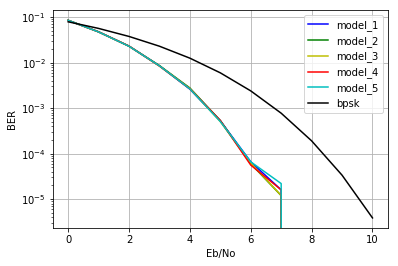

In [15]:
x = np.array(range(0, 11))

plt.semilogy(x,total_model_1_BER, label='model_1', color='b')
plt.semilogy(x,total_model_2_BER, label='model_2', color='g')
plt.semilogy(x,total_model_3_BER, label='model_3', color='y')
plt.semilogy(x,total_model_4_BER, label='model_4', color='r')
plt.semilogy(x,total_model_5_BER, label='model_5', color='c')


plt.semilogy(x,bpsk_BER, label='bpsk', color='k')


plt.xlabel('Eb/No')
plt.ylabel('BER')

plt.legend()
plt.grid(True)
plt.show()